In [ ]:
### Useuful functions in data loading and data visualization are from 
### "http://github.com/hwalsyklee/tnesorflow-mnist-VAE"

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gzip
from scipy.misc import imsave
from scipy.misc import imresize

# Parameters

In [2]:
learning_rate = 0.0003

n_hidden = 256
img_size = 28
n_channel = 1
pixel_depth = 255

dim_z = 2

n_input=img_size*img_size
n_output = n_input
n_class = 10

batch_size =128
n_train = 60000
n_test = 10000
n_batch = int(n_train/batch_size)

n_epochs = 100
add_noise = True
PMLR_n_samples=5000
print_step=1

# Data Load

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./mnist_data", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
def extract_data(filename, num_images, norm_shift=False, norm_scale=True):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(img_size * img_size * num_images * n_channel)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        if norm_shift:
            data = data - (pixel_depth / 2.0)
        if norm_scale:
            data = data / pixel_depth
        data = data.reshape(num_images, img_size, img_size, n_channel)
        data = np.reshape(data, [num_images, -1])
    return data

# Extract the labels
def extract_labels(filename, num_images):
    """Extract the labels into a vector of int64 label IDs."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        num_labels_data = len(labels)
        one_hot_encoding = np.zeros((num_labels_data, n_class))
        one_hot_encoding[np.arange(num_labels_data), labels] = 1
        one_hot_encoding = np.reshape(one_hot_encoding, [-1, n_class])
    return one_hot_encoding

In [5]:
path = './mnist_data/'

train_data   = extract_data(path + 'train-images-idx3-ubyte.gz', 60000, False, True)
train_label  = extract_labels(path + 'train-labels-idx1-ubyte.gz', 60000)
test_data    = extract_data(path + 't10k-images-idx3-ubyte.gz', 10000, False, True)
test_label   = extract_labels(path + 't10k-labels-idx1-ubyte.gz', 10000)

print(train_data.shape)
print(train_label.shape)

Extracting ./mnist_data/train-images-idx3-ubyte.gz
Extracting ./mnist_data/train-labels-idx1-ubyte.gz
Extracting ./mnist_data/t10k-images-idx3-ubyte.gz
Extracting ./mnist_data/t10k-labels-idx1-ubyte.gz
(60000, 784)
(60000, 10)


# Model

In [6]:
### Encoder

def encoder(x, n_hidden, keep_prob, dim_z):

    with tf.variable_scope("encoder"):
    
        w_e_init = tf.contrib.layers.variance_scaling_initializer() # He initializer
        b_e_init = tf.constant_initializer(0.)
    
        # 1st hidden layer
        w_e1 = tf.get_variable('w_e1', [x.shape[1], n_hidden], initializer=w_e_init)
        b_e1 = tf.get_variable('b_e1', [n_hidden], initializer=b_e_init)
        h_e1 = tf.add(tf.matmul(x, w_e1), b_e1)
        h_e1 = tf.nn.leaky_relu(h_e1)
        h_e1 = tf.nn.dropout(h_e1, keep_prob)
    
        # 2nd hidden layer
        w_e2 = tf.get_variable('w_e2', [h_e1.shape[1], n_hidden], initializer=w_e_init)
        b_e2 = tf.get_variable('b_e2', [n_hidden], initializer=b_e_init)
        h_e2 = tf.add(tf.matmul(h_e1, w_e2), b_e2)
        h_e2 = tf.nn.leaky_relu(h_e2)
        h_e2 = tf.nn.dropout(h_e2, keep_prob)
    
        # output layer
        w_eo = tf.get_variable('w_eo', [h_e2.shape[1], dim_z], initializer=w_e_init)
        b_eo = tf.get_variable('b_eo', [dim_z], initializer=b_e_init)
        h_eo = tf.add(tf.matmul(h_e2, w_eo), b_eo)
        h_eo = tf.nn.leaky_relu(h_eo)
    
    return h_eo

  
### Decoder   

def decoder(z, n_hidden, n_output, reuse=False):

    with tf.variable_scope('decoder', reuse=reuse):
    
        w_d_init = tf.contrib.layers.variance_scaling_initializer() # He initializer
        b_d_init = tf.constant_initializer(0.)
    
        # 1st hidden layer
        w_d1 = tf.get_variable('w_d1', [z.shape[1], n_hidden], initializer=w_d_init)
        b_d1 = tf.get_variable('b_d1', [n_hidden], initializer=b_d_init)
        h_d1 = tf.add(tf.matmul(z, w_d1), b_d1)
        h_d1 = tf.nn.leaky_relu(h_d1)
    
        # 2nd hidden layer
        w_d2 = tf.get_variable('w_d2', [h_d1.shape[1], n_hidden], initializer=w_d_init)
        b_d2 = tf.get_variable('b_d2', [n_hidden], initializer=b_d_init)
        h_d2 = tf.add(tf.matmul(h_d1, w_d2), b_d2)
        h_d2 = tf.nn.leaky_relu(h_d2)
    
        # output layer-mean
        w_do = tf.get_variable('w_do', [h_d2.shape[1], n_output], initializer=w_d_init)
        b_do = tf.get_variable('b_do', [n_output], initializer=b_d_init)
        y = tf.add(tf.matmul(h_d2, w_do), b_do)
        y = tf.sigmoid(y)
        y = tf.clip_by_value(y, 1e-8, 1-1e-8)
    
    return y

In [7]:
X_input = tf.placeholder(tf.float32, shape=[None, n_input])
X_output = tf.placeholder(tf.float32, shape=[None, n_input])
Y = tf.placeholder(tf.float32, shape=[None, n_class])
keep_prob = tf.placeholder(tf.float32)

manifold = encoder(X_input, n_hidden, keep_prob, dim_z)    
X_recover = decoder(manifold, n_hidden, n_output)

### loss
loss = - tf.reduce_sum(X_output*tf.log(X_recover) + (1-X_output)*tf.log(1-X_recover), axis=1)
loss = tf.reduce_mean(loss)

### optimization
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Decoder
manifold_in = tf.placeholder(tf.float32, shape=[None, dim_z])
decoded = decoder(manifold_in, n_hidden, n_output, reuse=True)

# Training

In [8]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [9]:
def ruota_antiorario(matrix):
    ruota=list(zip(*reversed(matrix)))
    return np.array([list(elemento) for elemento in ruota])

[0th epoch] loss: 219.347181


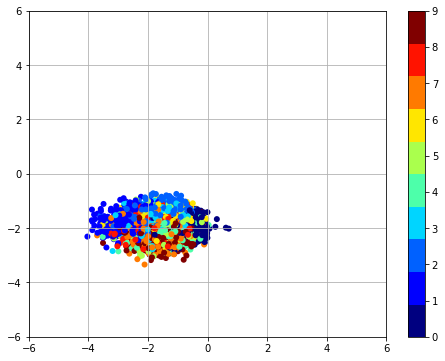

[1th epoch] loss: 192.258401


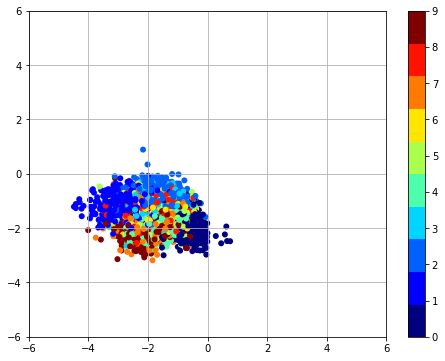

[2th epoch] loss: 188.441221


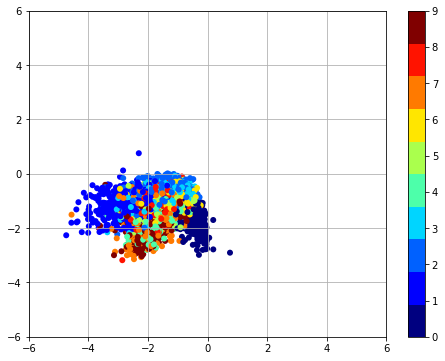

[3th epoch] loss: 184.993259


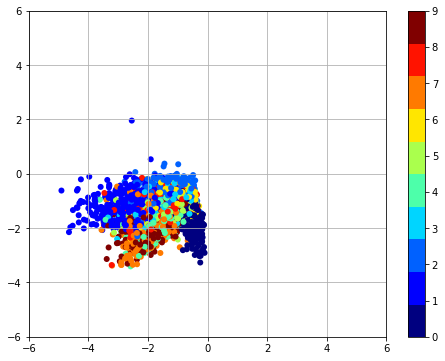

[4th epoch] loss: 182.530603


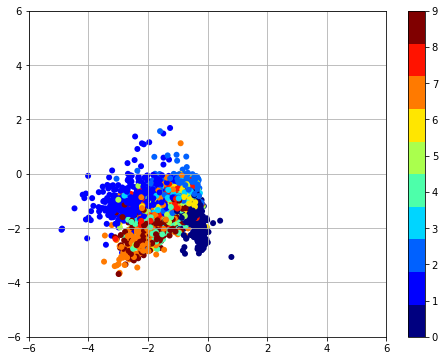

[5th epoch] loss: 181.053916


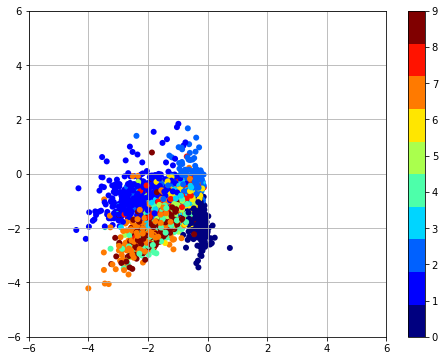

[6th epoch] loss: 179.611685


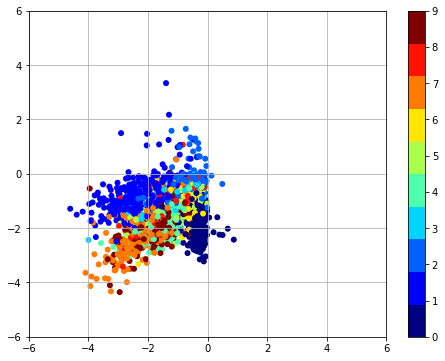

[7th epoch] loss: 178.276537


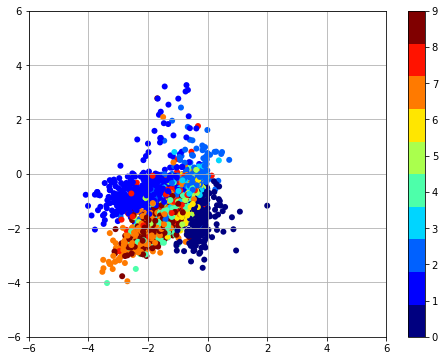

[8th epoch] loss: 176.672010


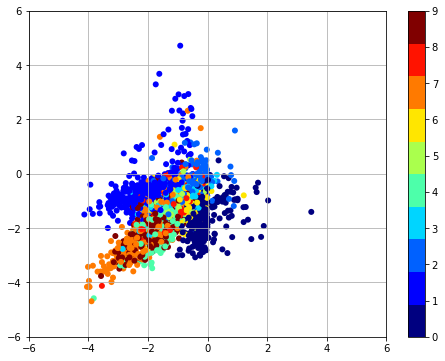

[9th epoch] loss: 175.433803


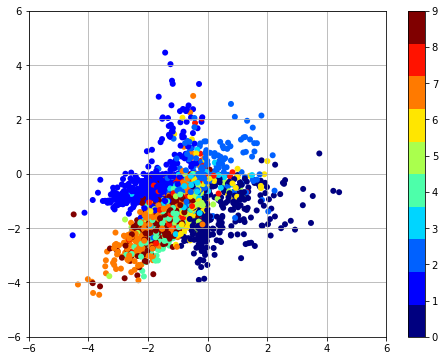

[10th epoch] loss: 174.508403


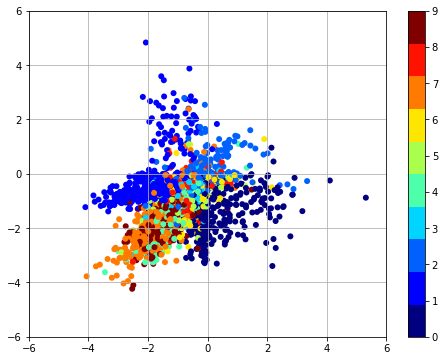

[11th epoch] loss: 173.627824


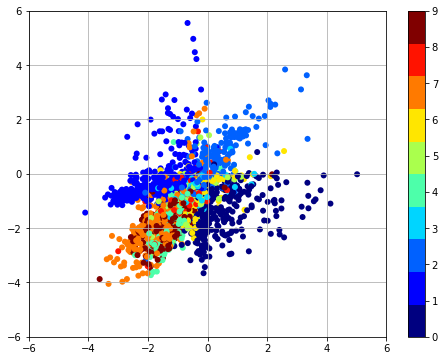

[12th epoch] loss: 172.842220


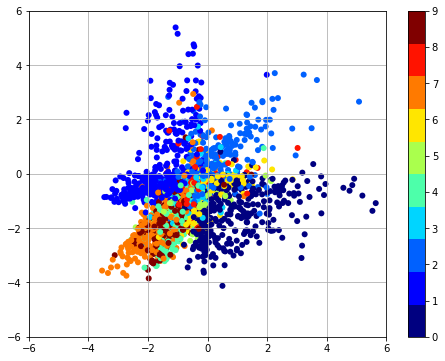

[13th epoch] loss: 172.195705


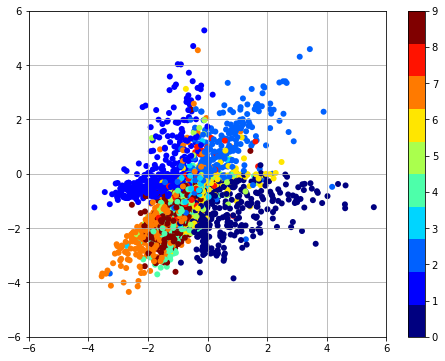

[14th epoch] loss: 171.410391


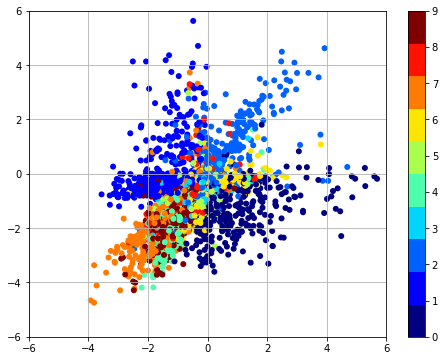

[15th epoch] loss: 170.823482


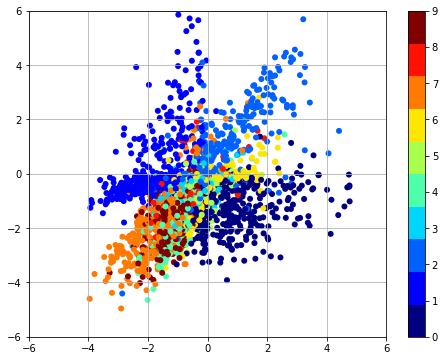

[16th epoch] loss: 170.108904


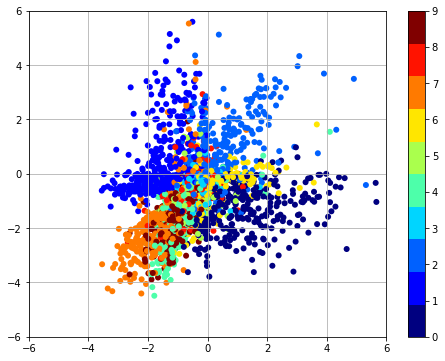

[17th epoch] loss: 169.576771


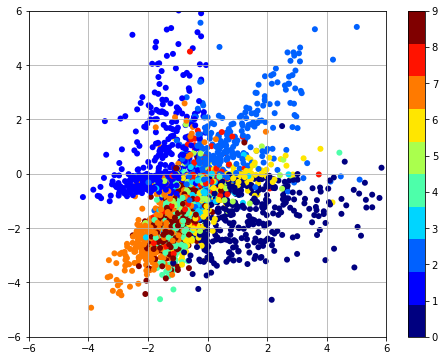

[18th epoch] loss: 169.217739


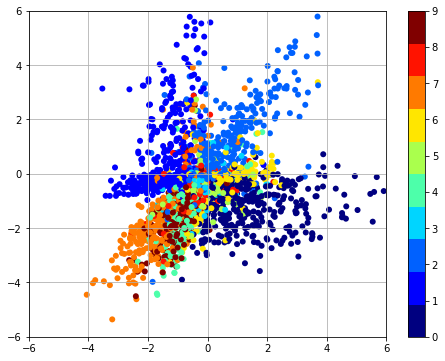

[19th epoch] loss: 168.741752


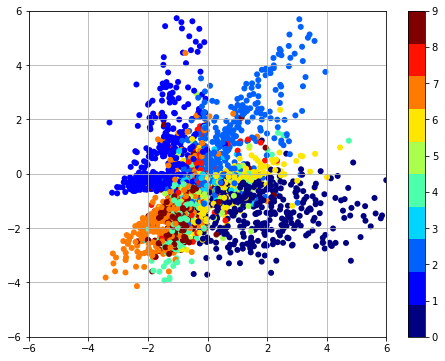

[20th epoch] loss: 168.225414


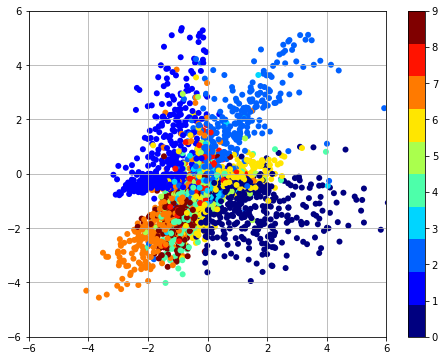

[21th epoch] loss: 167.744645


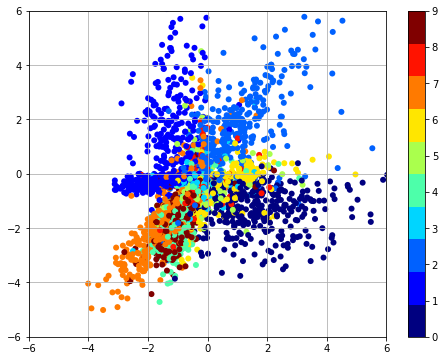

[22th epoch] loss: 167.534488


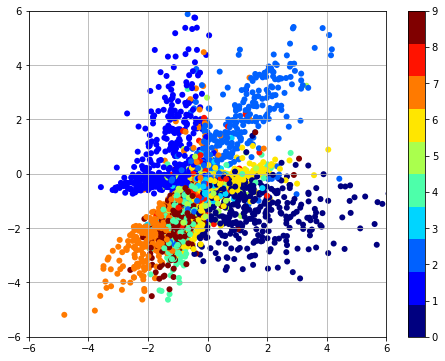

[23th epoch] loss: 167.261963


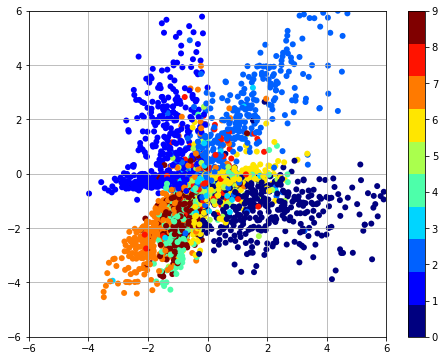

[24th epoch] loss: 167.038229


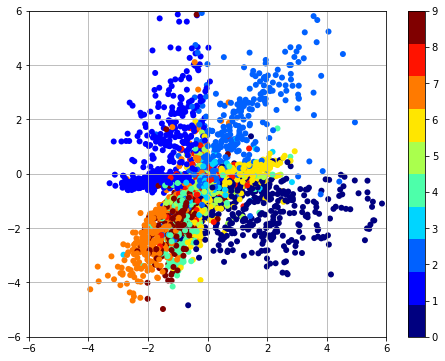

[25th epoch] loss: 166.516461


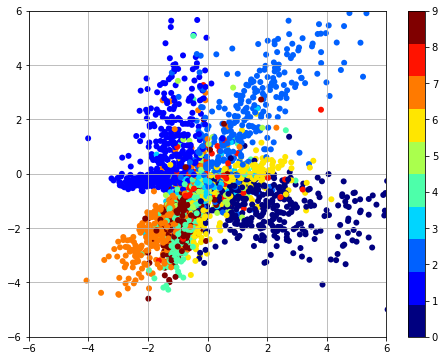

[26th epoch] loss: 166.535294


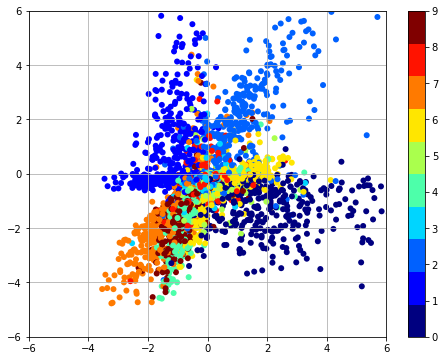

[27th epoch] loss: 166.061782


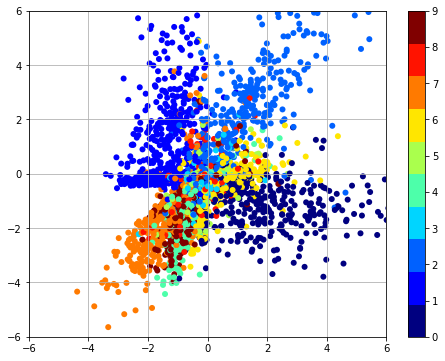

[28th epoch] loss: 165.803267


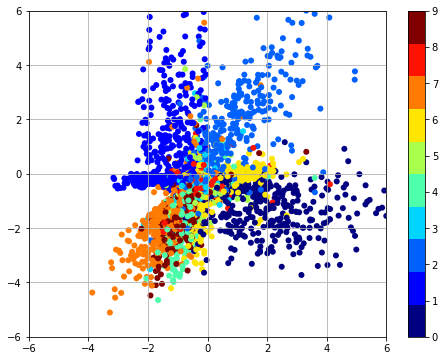

[29th epoch] loss: 165.747389


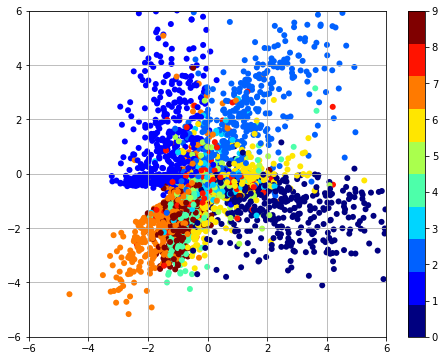

[30th epoch] loss: 165.464935


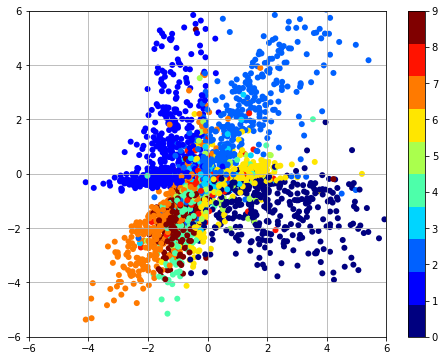

[31th epoch] loss: 165.216988


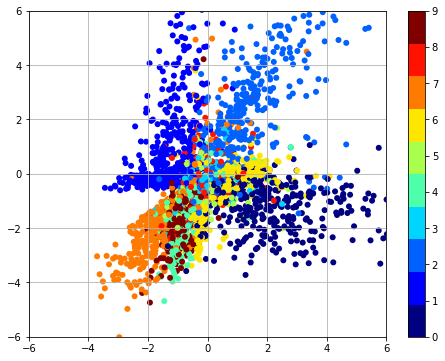

[32th epoch] loss: 164.971594


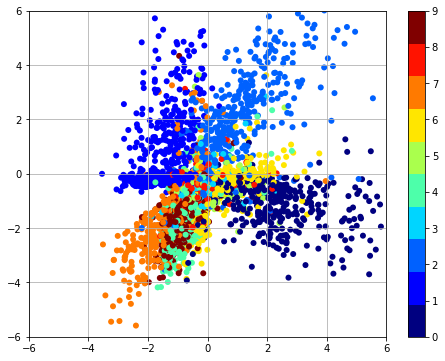

[33th epoch] loss: 164.996697


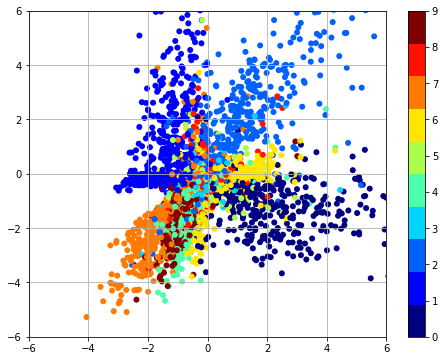

[34th epoch] loss: 164.648413


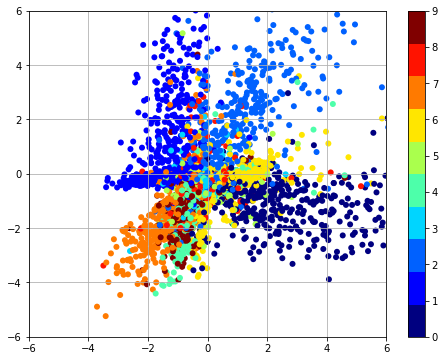

[35th epoch] loss: 164.621234


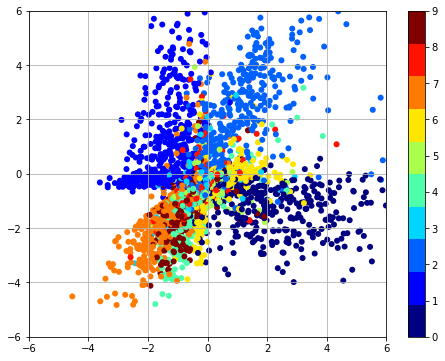

[36th epoch] loss: 164.630329


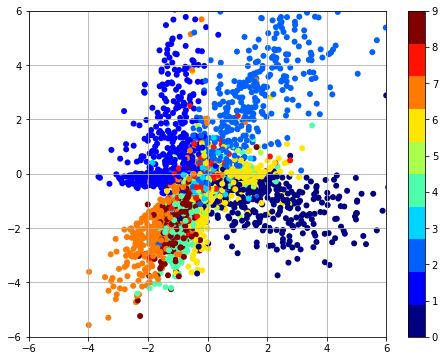

[37th epoch] loss: 164.393013


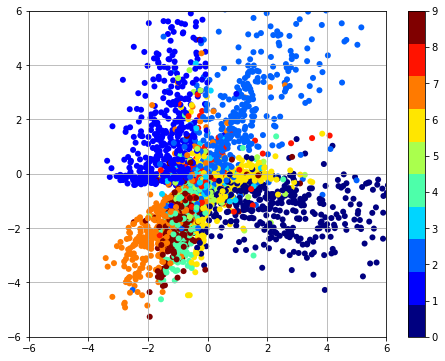

[38th epoch] loss: 164.141832


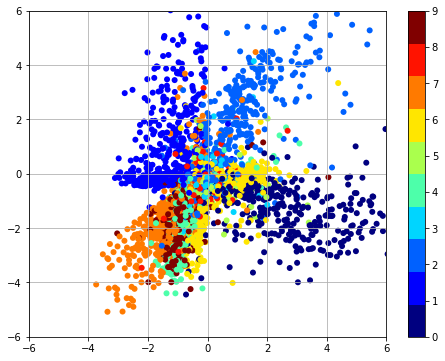

[39th epoch] loss: 163.998220


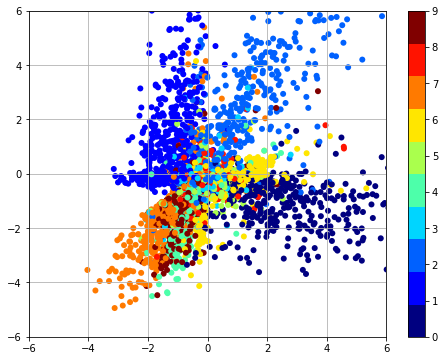

[40th epoch] loss: 164.085260


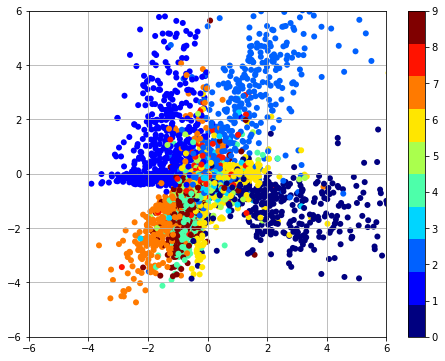

[41th epoch] loss: 163.936612


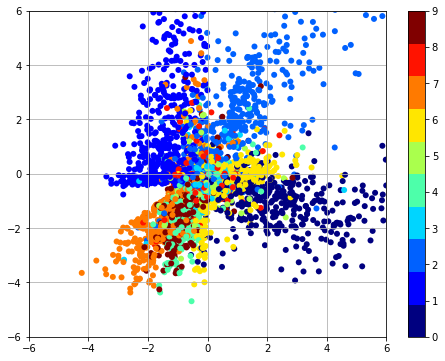

[42th epoch] loss: 163.856181


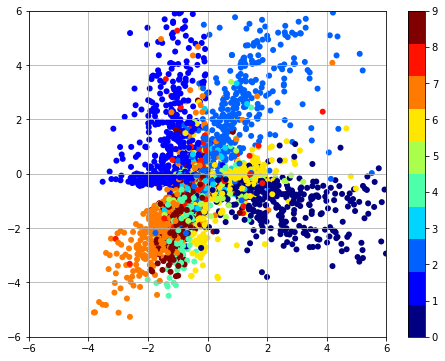

[43th epoch] loss: 163.541559


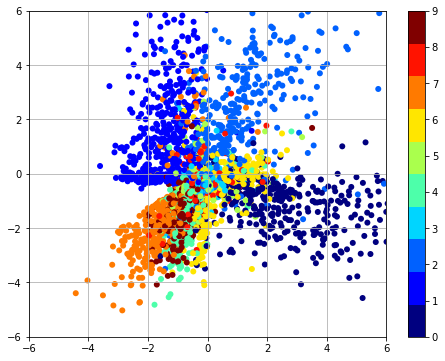

[44th epoch] loss: 163.355694


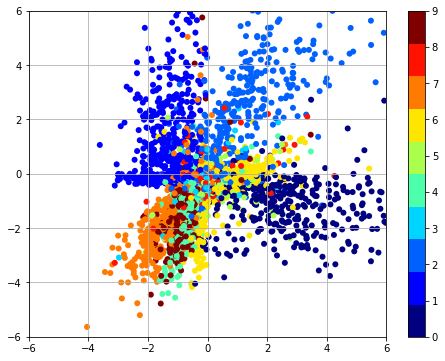

[45th epoch] loss: 163.366679


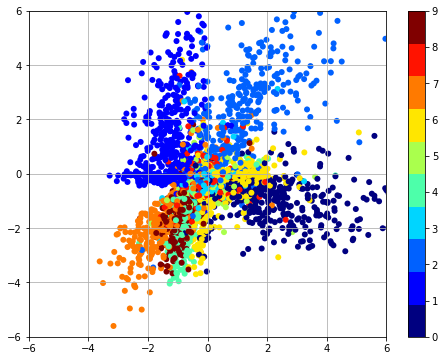

[46th epoch] loss: 163.251575


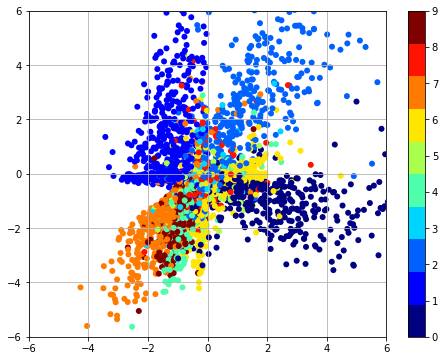

[47th epoch] loss: 163.312806


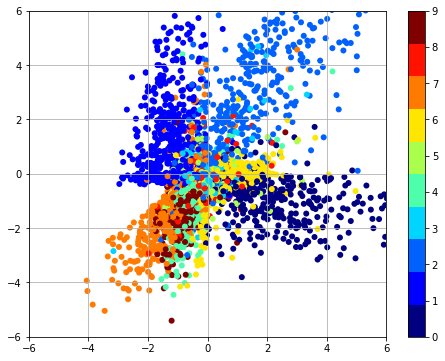

[48th epoch] loss: 163.181279


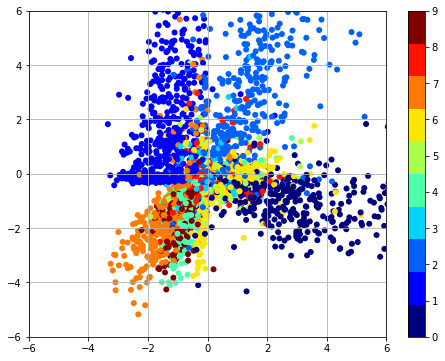

[49th epoch] loss: 163.136361


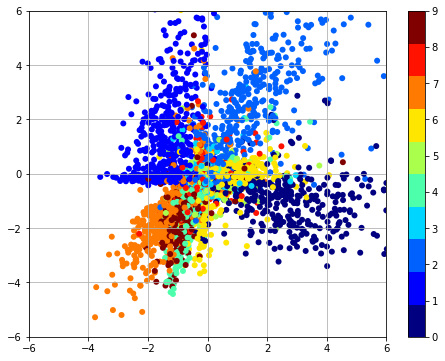

[50th epoch] loss: 162.934824


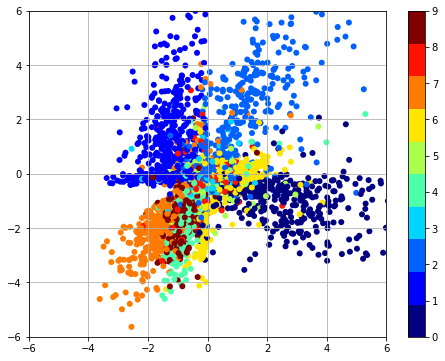

[51th epoch] loss: 162.969351


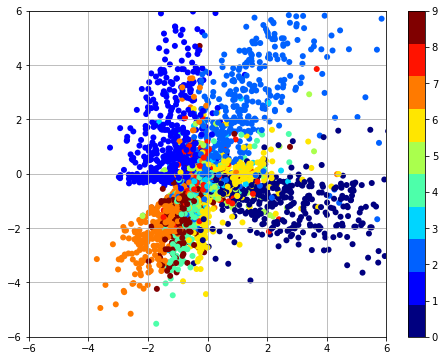

[52th epoch] loss: 162.648321


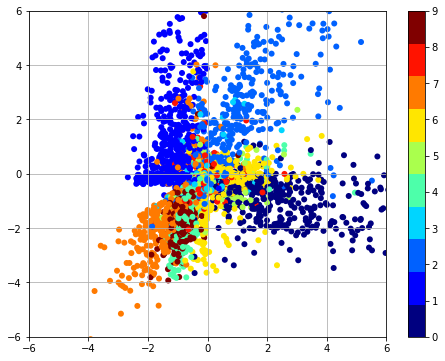

[53th epoch] loss: 162.838616


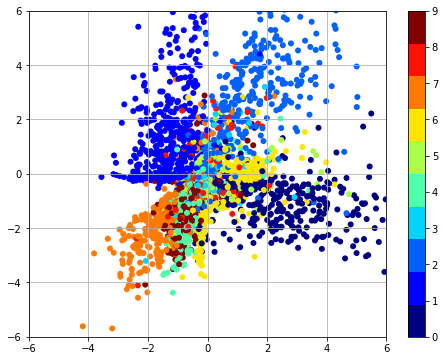

[54th epoch] loss: 162.698822


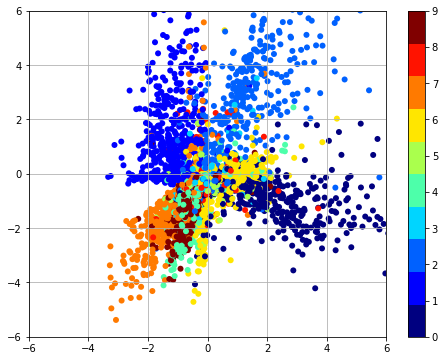

[55th epoch] loss: 162.579819


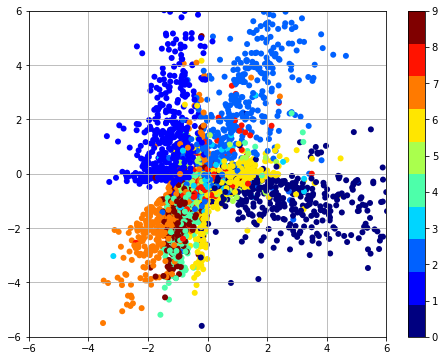

[56th epoch] loss: 162.543518


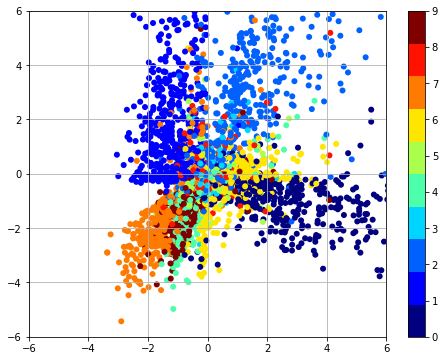

[57th epoch] loss: 162.486818


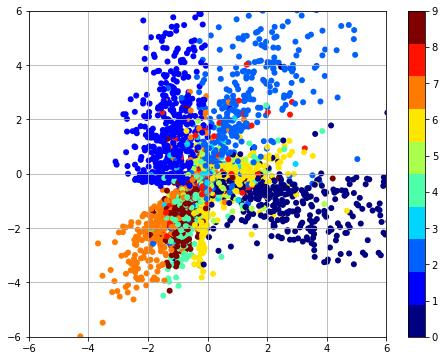

[58th epoch] loss: 162.336381


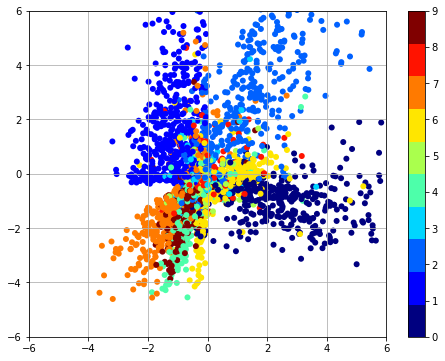

[59th epoch] loss: 162.330403


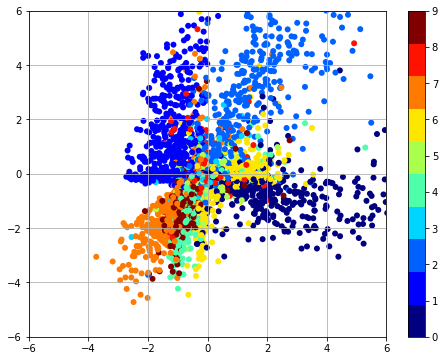

[60th epoch] loss: 162.317659


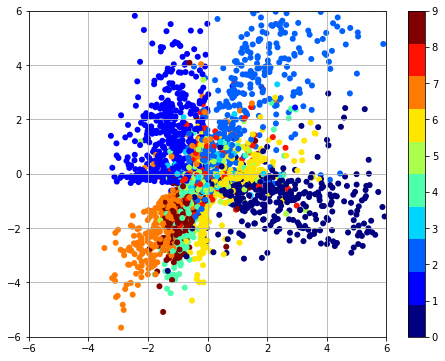

[61th epoch] loss: 162.111714


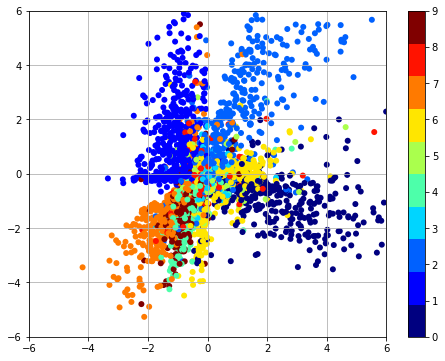

[62th epoch] loss: 162.152357


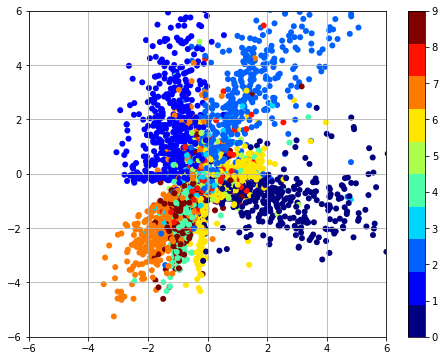

[63th epoch] loss: 162.278801


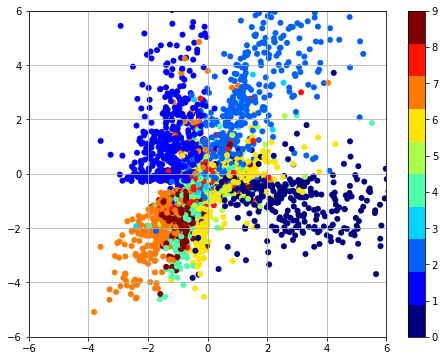

[64th epoch] loss: 162.083474


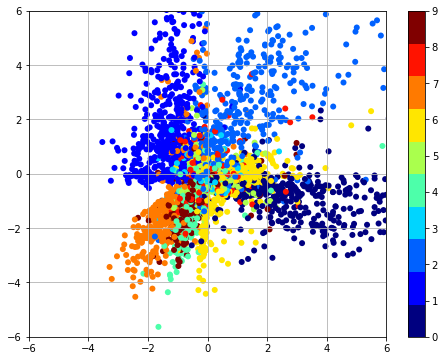

[65th epoch] loss: 161.935367


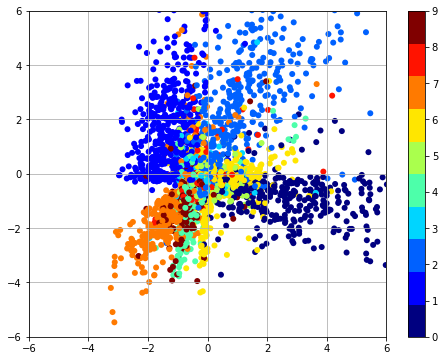

[66th epoch] loss: 161.976984


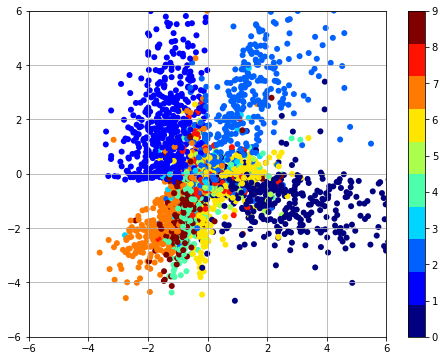

[67th epoch] loss: 161.977957


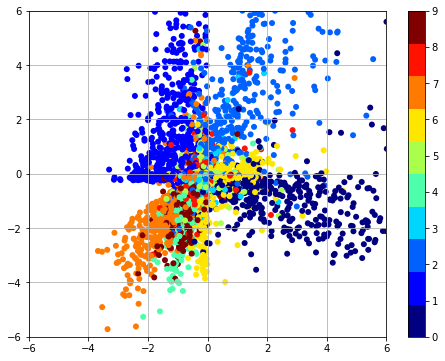

[68th epoch] loss: 161.750647


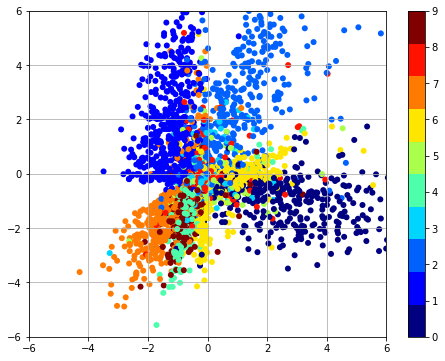

[69th epoch] loss: 161.863627


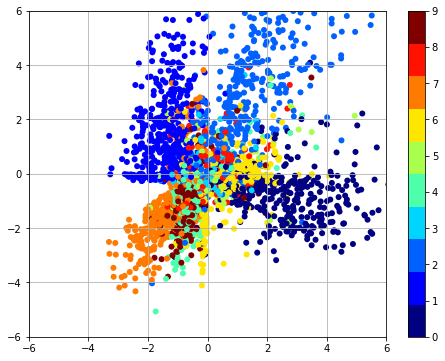

[70th epoch] loss: 161.698499


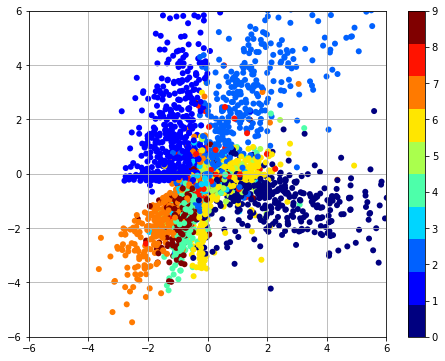

[71th epoch] loss: 161.613927


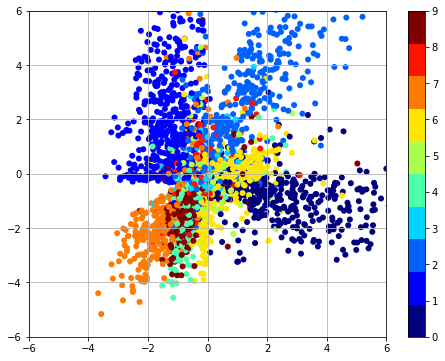

[72th epoch] loss: 161.938049


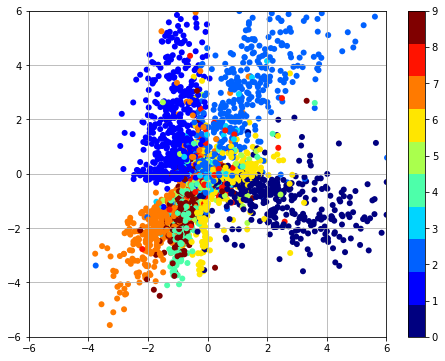

[73th epoch] loss: 161.648300


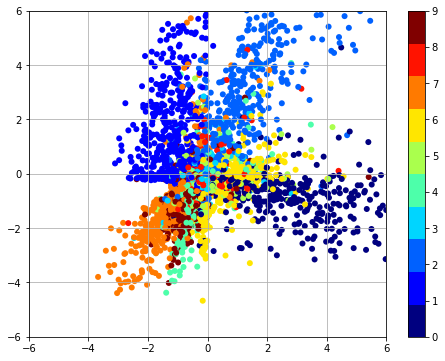

[74th epoch] loss: 161.576194


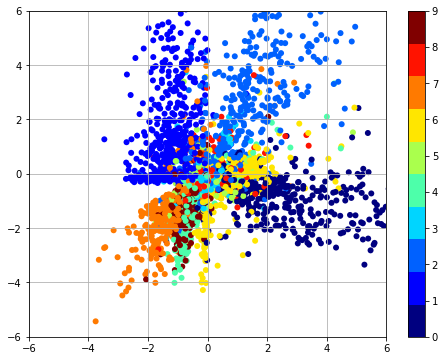

[75th epoch] loss: 161.599057


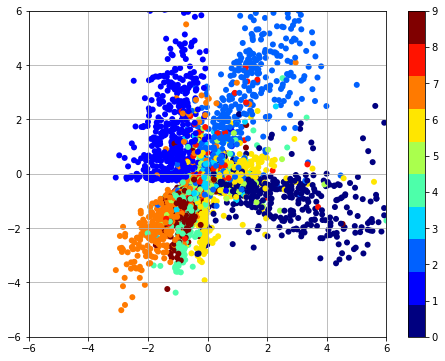

[76th epoch] loss: 161.255339


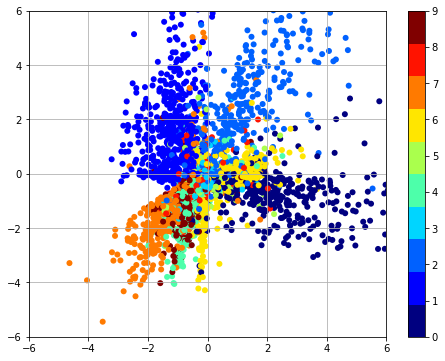

[77th epoch] loss: 161.341155


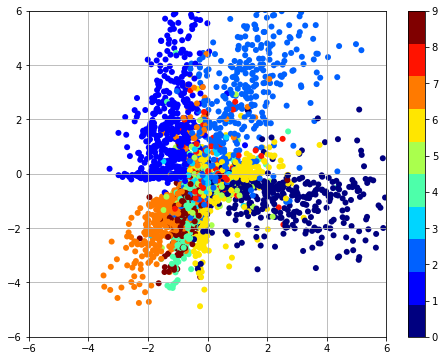

[78th epoch] loss: 161.470726


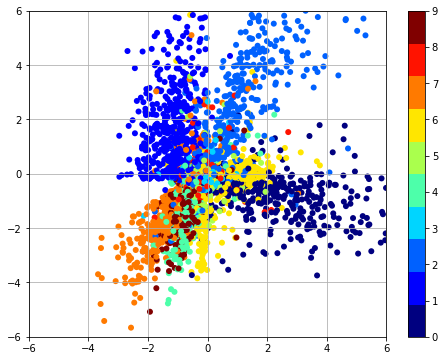

[79th epoch] loss: 161.391328


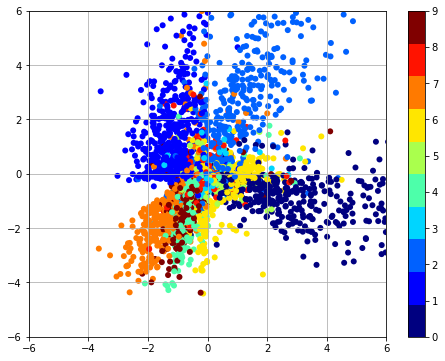

[80th epoch] loss: 161.270268


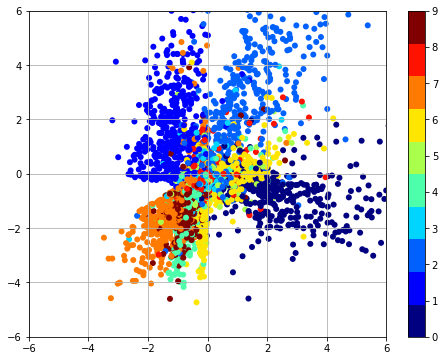

[81th epoch] loss: 161.419494


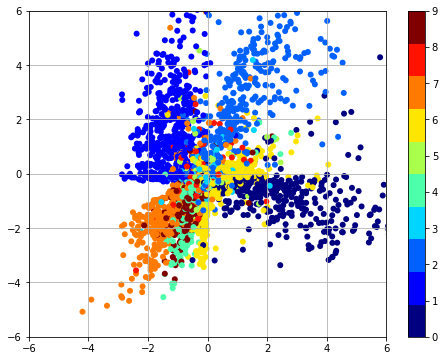

[82th epoch] loss: 161.269821


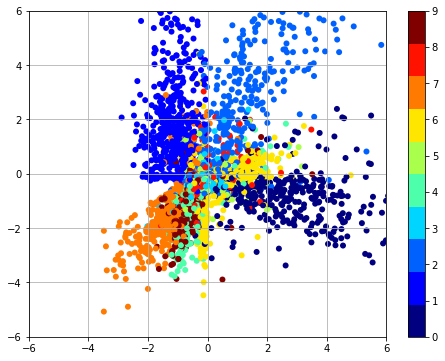

[83th epoch] loss: 161.270922


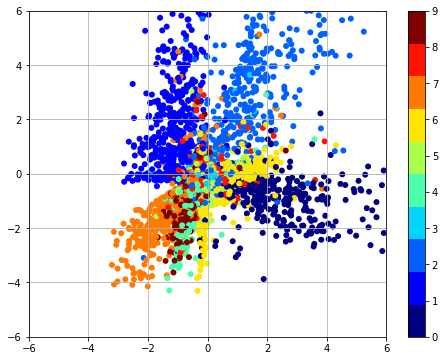

[84th epoch] loss: 161.123563


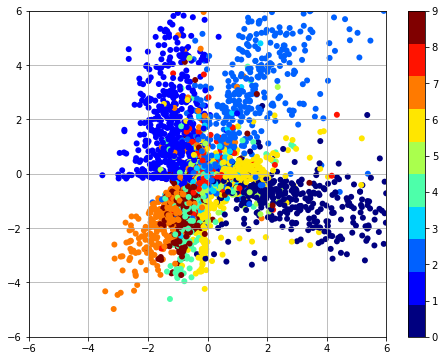

[85th epoch] loss: 161.096263


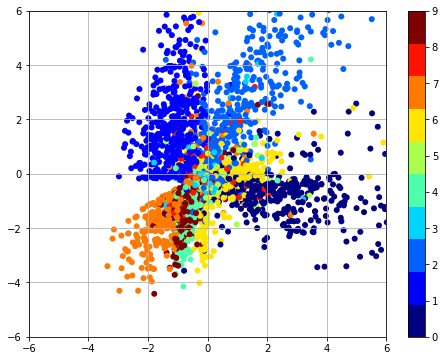

[86th epoch] loss: 161.070618


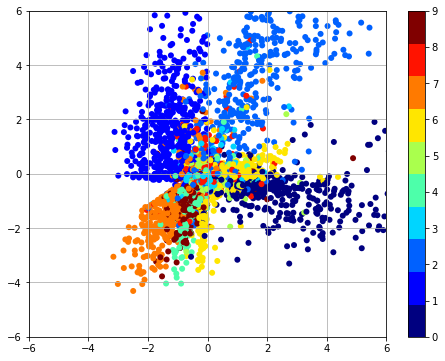

[87th epoch] loss: 160.980666


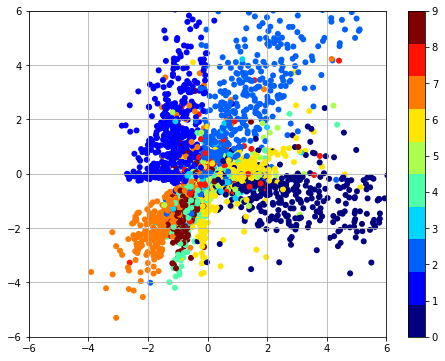

[88th epoch] loss: 161.111978


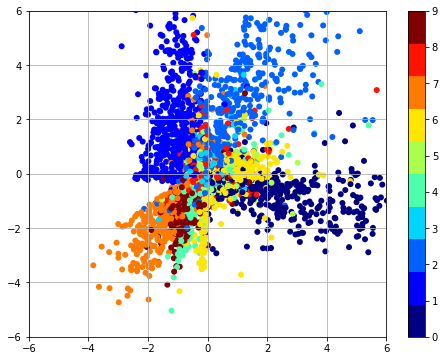

[89th epoch] loss: 161.112836


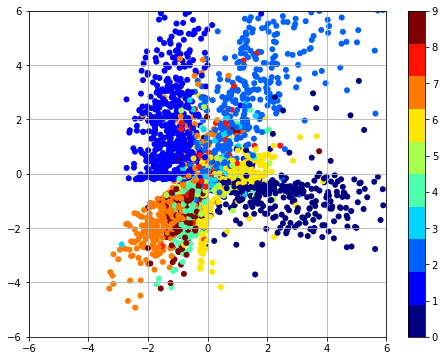

[90th epoch] loss: 160.899281


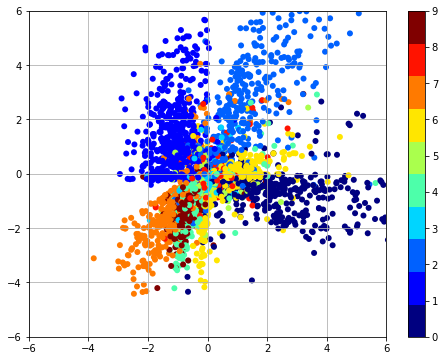

[91th epoch] loss: 160.799649


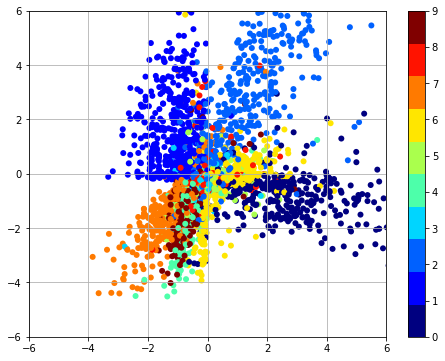

[92th epoch] loss: 160.929876


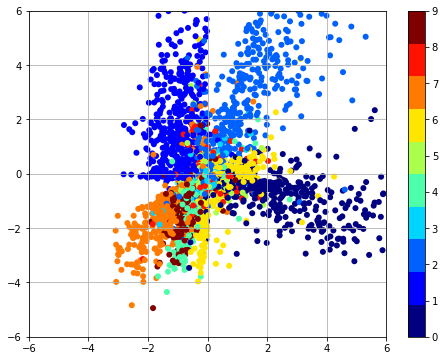

[93th epoch] loss: 160.993307


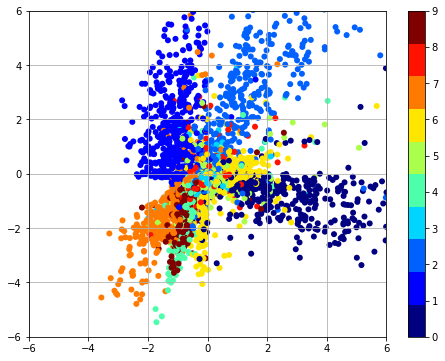

[94th epoch] loss: 160.801318


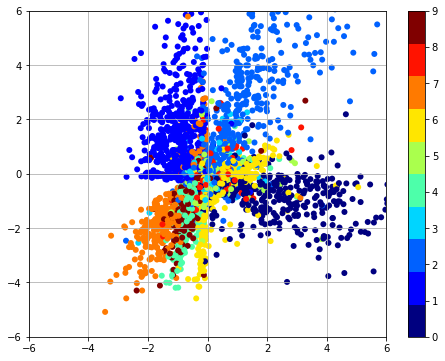

[95th epoch] loss: 160.950802


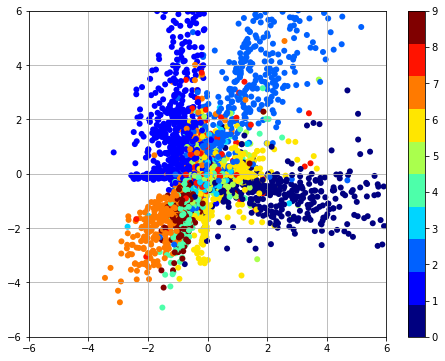

[96th epoch] loss: 160.784221


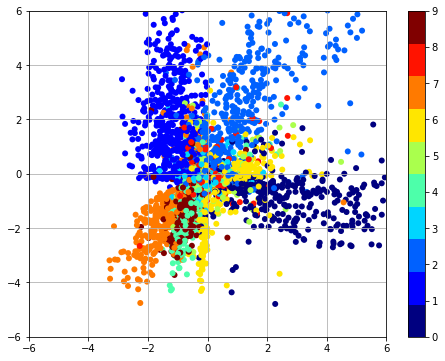

[97th epoch] loss: 160.749714


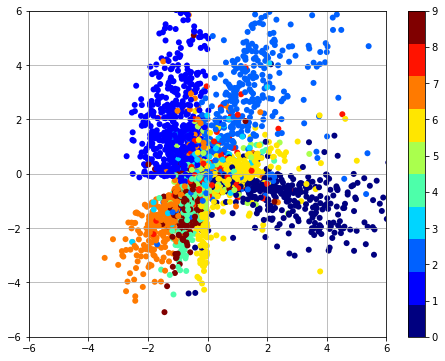

[98th epoch] loss: 160.890708


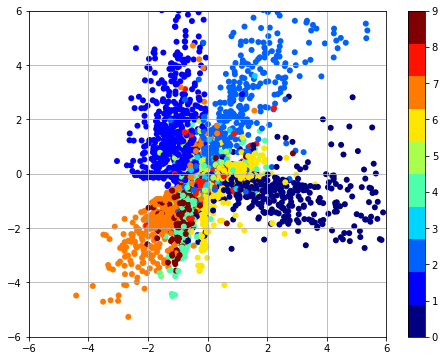

[99th epoch] loss: 160.667716


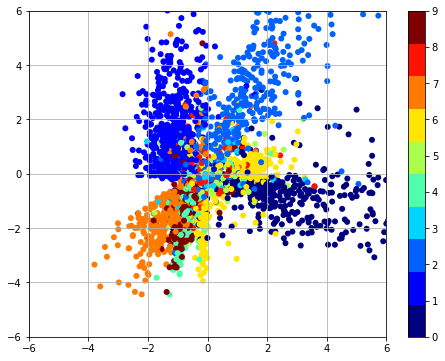

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epochs):
        
        batch_order=list(range(train_data.shape[0]))
        np.random.shuffle(batch_order)
        
        a_loss = 0
        
        b=0
        while b <= train_data.shape[0]:
            if b+batch_size >= train_data.shape[0]:
                b_ = train_data.shape[0]
            else:
                b_ = b + batch_size

            batch_x_input = train_data[batch_order[b:b_],:]
            batch_x_target = batch_x_input
            batch_y_input = train_label[batch_order[b:b_]]
            
            if add_noise:
                batch_x_input = (batch_x_input * np.random.randint(2, size=batch_x_input.shape)) + np.random.randint(2, size=batch_x_input.shape)
            
            _, b_loss = sess.run((train, loss), 
                                 feed_dict={X_input: batch_x_input, 
                                                X_output: batch_x_target, 
                                                Y: batch_y_input,
                                                keep_prob: 0.9})
            
            a_loss += b_loss / (train_data.shape[0] // batch_size)
            b += batch_size
            #print(b, b_loss)
        
        print("[%dth epoch] loss: %f" % (epoch, a_loss))
        
        # Plot Manifolded Learning Result
        if dim_z == 2:
            if epoch%print_step == 0:
                z_range = 6
                interval = 20
    
                #z_map = np.rollaxis(np.mgrid[z_range:-z_range:interval*1j, z_range:-z_range:interval*1j], 0, 3).reshape([-1, 2])
                z_map = ruota_antiorario(np.rollaxis(np.mgrid[z_range:-z_range:interval*1j, z_range:-z_range:interval*1j], 0, 3)).reshape([-1, 2])
            
                x_PMLR = test_data[0:PMLR_n_samples, :]
                x_PMLR_noise = (x_PMLR * np.random.randint(2, size=x_PMLR.shape)) + np.random.randint(2, size=x_PMLR.shape)

                id_PMLR = test_label[0:PMLR_n_samples, :]
    
                if add_noise:
                    z_PMLR = sess.run(manifold, feed_dict={X_input: x_PMLR_noise, keep_prob: 1.0})
                else:
                    z_PMLR = sess.run(manifold, feed_dict={X_input: x_PMLR, keep_prob: 1.0})
        
                y_PMLR = sess.run(decoded, feed_dict={manifold_in: z_map, keep_prob: 1.0})
        
                N = 10
                plt.figure(figsize=(8, 6))
                
                plt.scatter(z_PMLR[:, 0], z_PMLR[:, 1], c=np.argmax(id_PMLR, 1), marker='o', edgecolor='none', cmap=discrete_cmap(N, 'jet'))
                plt.colorbar(ticks=range(N))
                axes = plt.gca()
                axes.set_xlim([-z_range, z_range])
                axes.set_ylim([-z_range, z_range])
                plt.grid(True)
                plt.savefig('./figure/'+str(epoch)+'.png', bbox_inches='tight')
                plt.show()
                
    
    
    # Plot Reproduce Performance
    performance_size = 8
    
    x_PRR = test_data[0:performance_size**2, :]
    id_PRR = test_label[0:performance_size**2, :]
    
    x_PRR_noise = (x_PRR * np.random.randint(2, size=x_PRR.shape)) + np.random.randint(2, size=x_PRR.shape)
    
    if add_noise:
        y_PRR = sess.run(X_recover, feed_dict={X_input: x_PRR_noise, keep_prob: 1.0})
    else:
        y_PRR = sess.run(X_recover, feed_dict={X_input: x_PRR, Y: id_PRR, keep_prob: 1.0})
        
    y_PRR_img = y_PRR.reshape(performance_size**2, img_size, img_size)
    

    # Plot for analogy result
    if dim_z == 2:
        v = z_range*0.7 # inorder to maximize style-difference, let's peak 4 points
        nx_PARR = 11
        ny_PARR = 4
        z_points = [[v, v], [-v, v], [v, -v], [-v, -v]]
        repeat_shape = list(np.int32(np.ones(ny_PARR)*nx_PARR))

        z_points = np.repeat(z_points, repeat_shape, 0)
        z_points = np.clip(z_points, -z_range, z_range)
    
        y_PARR = sess.run(decoded, feed_dict={manifold_in: z_points, keep_prob: 1})

# Plot Reproduce Performance

In [12]:
def merge(images, size):
    resize_factor = 1
    h_ = img_size * resize_factor
    w_ = img_size * resize_factor

    img = np.zeros([h_*size, w_*size])

    for idx, image in enumerate(images):

        i = int(idx % size)
        j = int(idx / size)
    
        image_ = imresize(image, size=(w_,h_), interp='bicubic')
        img[j*h_:j*h_+h_, i*w_:i*w_+w_] = image_
        
    return img

/Users/rackhun/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


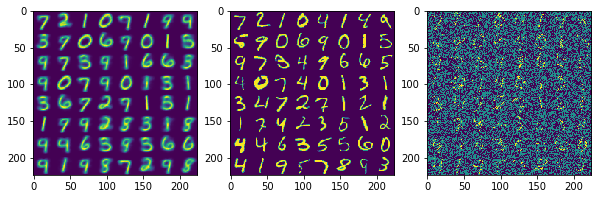

In [13]:
result = merge(y_PRR_img, performance_size)
original = merge(test_data[0:performance_size**2, :].reshape(performance_size**2, img_size, img_size), performance_size)
noise = merge(x_PRR_noise.reshape(performance_size**2, img_size, img_size), performance_size)

plt.figure(figsize=(10, 30))

plt.subplot(1, 3, 1)
plt.imshow(result)
plt.subplot(1, 3, 2)
plt.imshow(original)
    
if add_noise:
    plt.subplot(1, 3, 3)
    plt.imshow(noise)

# Plot Manifold Learning Result

/Users/rackhun/miniconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


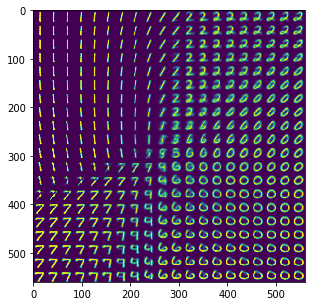

In [14]:
y_PMLR_img = y_PMLR.reshape(interval**2, img_size, img_size)
PMLR_result = merge(y_PMLR_img, interval)

plt.figure(figsize=(5, 5))
plt.imshow(PMLR_result)